The objevtive is to create a RFM model for the CRC detections

Load the libraries

In [1]:
import pandas as pd
import os
import datetime as dt
# from helpers.queries import *
import streamlit.components.v1 as components
from IPython.core.display import display, HTML
import streamlit as st
# from helpers.password import *
import plotly.graph_objects as go
from scipy import stats



C:\Users\cladi\AppData\Local\Temp\ipykernel_19296\715141931.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Load the data

In [2]:

directory="G:/My Drive/Project Lighthouse/project_lighthouse/webApp/helpers/queries.py"

# #ec2
# directory="/home/ubuntu/project_crc/webApp/queries.py"

with open(directory) as infile:
    exec(infile.read())
    
selected_time_range_ini=pd.to_datetime('06-01-2023 00:00')
selected_time_range_end=pd.to_datetime('06-30-2023 23:59')

print(selected_time_range_ini)
print(selected_time_range_end)

########### create a rfm model using crc data
#get the data
mydata=crc_between_datetimes(selected_time_range_ini,selected_time_range_end)
#print the number of rows
print(mydata.shape)
# mydata=mydata.head(1000)



2023-06-01 00:00:00
2023-06-30 23:59:00
(215505, 10)


Clean the data

In [3]:
#select only 'timestamp_utc','ip_address'
mydata=mydata[['timestamp_utc','ip_address']]
#order by ip_address and timestamp_utc
mydata=mydata.sort_values(by=['ip_address','timestamp_utc'])
print(mydata)


             timestamp_utc     ip_address
62149  2023-06-01 00:25:32        1.0.0.1
111583 2023-06-11 00:28:00        1.0.0.1
207281 2023-06-30 18:42:30        1.0.0.1
106308 2023-06-10 00:22:59    1.0.220.152
124320 2023-06-14 01:17:51    1.1.169.228
...                    ...            ...
43887  2023-06-24 07:10:43   99.98.97.123
46261  2023-06-25 05:44:53   99.98.97.123
46260  2023-06-25 05:46:01   99.98.97.123
24901  2023-06-12 02:15:29  99.99.248.168
57520  2023-06-29 01:01:37  99.99.248.168

[215505 rows x 2 columns]


Create the features

          ip_address  counts       timestamp_utc  days_since_today
0            1.0.0.1       3 2023-06-30 18:42:30                40
1        1.0.220.152       1 2023-06-10 00:22:59                61
2        1.1.169.228       2 2023-06-14 06:41:33                57
3       1.10.229.146       1 2023-06-30 19:22:46                40
4      1.116.217.211       1 2023-06-30 06:14:13                41
...              ...     ...                 ...               ...
59546   99.97.14.167       1 2023-06-12 04:01:54                59
59547  99.97.210.228       1 2023-06-13 03:31:00                58
59548   99.98.62.139      18 2023-06-29 00:00:55                42
59549   99.98.97.123       5 2023-06-25 05:46:01                46
59550  99.99.248.168       2 2023-06-29 01:01:37                42

[59551 rows x 4 columns]


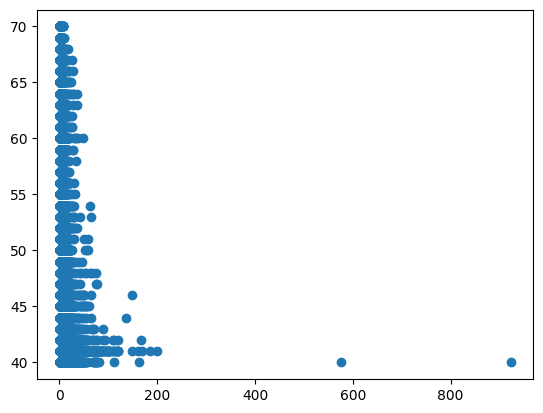

In [4]:
#####features
#calculate the number of times it appears
features=mydata.groupby('ip_address').size().reset_index(name='counts')
# print(features)
#calculate the last 'timestamp_utc' it appeared since today
# features['last_time_utc']=mydata.groupby('ip_address')['timestamp_utc'].max()
last_date_appeared=mydata.sort_values(by=['timestamp_utc']).drop_duplicates(subset='ip_address', keep='last')
#calculate the number of days since today
last_date_appeared['days_since_today']=last_date_appeared['timestamp_utc'].apply(lambda x: (dt.datetime.now() - x).days)    
# print(last_date_appeared)
#merge features with last_date_appeared
features=features.merge(last_date_appeared, on='ip_address', how='left')
print(features)
#drop the timestamp_utc column
features=features.drop(['timestamp_utc'], axis=1)
#plot the features in a scatterplot using matplotlib
import matplotlib.pyplot as plt
plt.scatter(features['counts'], features['days_since_today'])


Deeper analysis

In [5]:
from ydata_profiling import ProfileReport
profile = ProfileReport(features, title="Pandas Profiling Report")
profile.to_notebook_iframe()



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Select only the features and normalise them

In [6]:
#https://github.com/psrana/Machine-Learning-using-PyCaret/blob/main/03_PyCaret_for_Clustering_with_Results.ipynb
# from pycaret.clustering import *
import pandas as pd
from sklearn.preprocessing import StandardScaler
modelling_features=features
#drop ip_address column
modelling_features=modelling_features.drop(['ip_address'], axis=1)

#normalise the modelling_features
modelling_features=pd.DataFrame(StandardScaler().fit_transform(modelling_features),columns=modelling_features.columns)
print(modelling_features.head(10))

     counts  days_since_today
0 -0.077509         -1.254695
1 -0.328009          0.912523
2 -0.202759          0.499719
3 -0.328009         -1.254695
4 -0.328009         -1.151494
5 -0.202759         -1.151494
6 -0.328009          1.428527
7 -0.202759          1.222125
8 -0.328009         -1.151494
9 -0.328009         -0.532289


plot the features in a scatterplot

Text(0, 0.5, 'days_since_today')

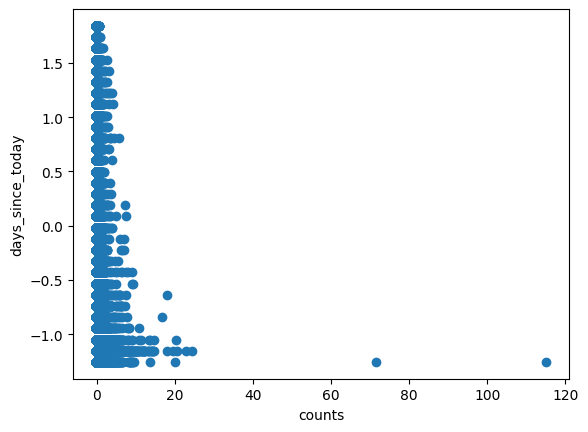

In [7]:
#plot the features in a scatterplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.scatter(modelling_features.counts, modelling_features.days_since_today)
plt.xlabel(modelling_features.columns[0])
plt.ylabel(modelling_features.columns[1])

Select the best k for kmeans

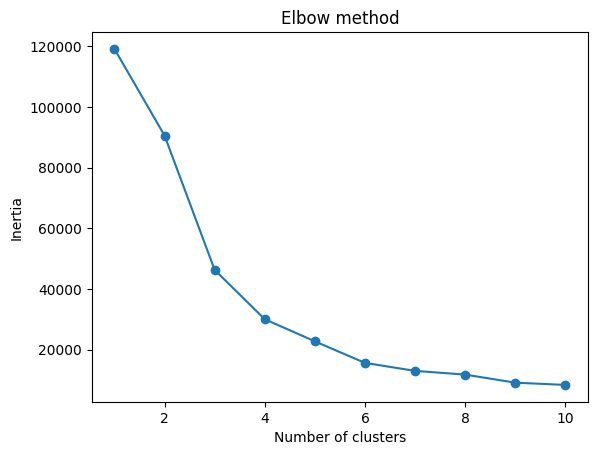

In [8]:
#Select the best k for kmeans

import numpy as np
from sklearn.cluster import KMeans

# data = list(zip(x, y))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,n_init="auto")
    kmeans.fit(modelling_features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Based on the graph above create five clusters

In [9]:
#sklearn cluster 5
my_model = KMeans(n_clusters=5,n_init="auto")
label = my_model.fit_predict(modelling_features)

print(label)

[4 1 0 ... 2 4 4]


Plot

<Axes: xlabel='counts', ylabel='days_since_today'>

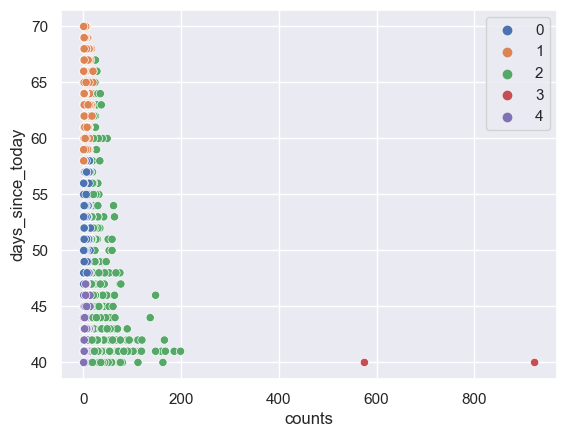

In [10]:
#plotting the results using seaborn

import seaborn as sns

sns.set(style="darkgrid")
sns.scatterplot(x=features.counts, y=features.days_since_today, hue=label,  palette="deep")

# plt.scatter(features.counts, features.days_since_today,c=label)
# plt.legend()
# plt.xlabel(modelling_features.columns[0])
# plt.ylabel(modelling_features.columns[1])

Centroids

In [11]:
#add to features the label
import pandas as pd
final_dataset=features.copy()
final_dataset['label']=label
final_dataset.head()
# final_dataset=pd.DataFrame(features,label)
# final_dataset.head()

,ip_address,counts,days_since_today,label
0,1.0.0.1,3,40,4
1,1.0.220.152,1,61,1
2,1.1.169.228,2,57,0
3,1.10.229.146,1,40,4
4,1.116.217.211,1,41,4


We can see 5 groups:
- C0 - low number of detections, the last connections is moderately old
- C1 - low number of detections, the last connection is old
- C2 - medium number of detections
- C3 - high number of detections, recent last connection
- C4 - low number of detections, recent last connection
